In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#read data for all the stocks
df=pd.read_csv("/content/gdrive/MyDrive/all_stocks_5yr.csv")
#get the data of the stock with the name "AAL"
aal_dataset = df[df.Name == "AAL"]

#we split the dataset into training, validation and testing subset
aal_training_len = round(len(aal_dataset) * 0.7)
aal_val_len = round(len(aal_dataset) * 0.1)

aal_training_set = aal_dataset.iloc[:aal_training_len, 4:5].values
aal_val_set = aal_dataset.iloc[aal_training_len:aal_training_len + aal_val_len, 4:5].values
aal_testing_set = aal_dataset.iloc[aal_training_len + aal_val_len:, 4:5].values

#we create a MinMaxScaler
aal_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = aal_scaler.fit_transform(aal_training_set.reshape(-1,1))
scaled_validation_data = aal_scaler.fit_transform(aal_val_set.reshape(-1,1))
scaled_test_data = aal_scaler.fit_transform(aal_testing_set.reshape(-1,1))

window = 20
X_train = []
y_train = []
for i in range(window, len(scaled_train_data)):
    X_train.append(scaled_train_data[i-window:i, 0])
    y_train.append(scaled_train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_val = []
y_val = []
for i in range(window, len(scaled_validation_data)):
    X_val.append(scaled_validation_data[i-window:i, 0])
    y_val.append(scaled_validation_data[i, 0])
X_val, y_val = np.array(X_val), np.array(y_val)

X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))


In [3]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train,validation_data = (X_val, y_val), epochs = 100, batch_size = 32)

Epoch 1/100
27/27 [==============================] - 9s 112ms/step - loss: 0.0733 - val_loss: 0.0216
Epoch 2/100
27/27 [==============================] - 1s 48ms/step - loss: 0.0121 - val_loss: 0.0221
Epoch 3/100
27/27 [==============================] - 1s 46ms/step - loss: 0.0079 - val_loss: 0.0215
Epoch 4/100
27/27 [==============================] - 1s 47ms/step - loss: 0.0075 - val_loss: 0.0266
Epoch 5/100
27/27 [==============================] - 1s 47ms/step - loss: 0.0077 - val_loss: 0.0235
Epoch 6/100
27/27 [==============================] - 1s 47ms/step - loss: 0.0075 - val_loss: 0.0192
Epoch 7/100
27/27 [==============================] - 1s 47ms/step - loss: 0.0069 - val_loss: 0.0198
Epoch 8/100
27/27 [==============================] - 1s 46ms/step - loss: 0.0068 - val_loss: 0.0231
Epoch 9/100
27/27 [==============================] - 1s 46ms/step - loss: 0.0065 - val_loss: 0.0221
Epoch 10/100
27/27 [==============================] - 1s 47ms/step - loss: 0.0063 - val_loss: 0.022

In [4]:
aal_training_set = pd.DataFrame(aal_training_set)
aal_testing_set = pd.DataFrame(aal_testing_set)

dataset_total = pd.concat((aal_training_set, aal_testing_set), axis=0)
inputs = dataset_total[len(dataset_total) - len(aal_testing_set) - window:].values
inputs = inputs.reshape(-1, 1)
inputs = aal_scaler.transform(inputs)

aal_X_test = []
for i in range(window, len(inputs)):
    aal_X_test.append(inputs[i-window:i, 0])
aal_X_test = np.array(aal_X_test)
aal_X_test = np.reshape(aal_X_test, (aal_X_test.shape[0], aal_X_test.shape[1], 1))
aal_predicted_stock_price = model.predict(aal_X_test)
aal_predicted_stock_price = aal_scaler.inverse_transform(aal_predicted_stock_price)
#print(aal_predicted_stock_price)
print(len(aal_predicted_stock_price))

252


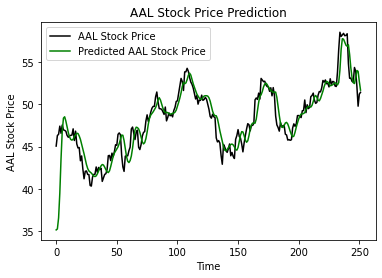

In [5]:
plt.plot(aal_testing_set, color = 'black', label = 'AAL Stock Price')
plt.plot(aal_predicted_stock_price, color = 'green', label = 'Predicted AAL Stock Price')
plt.title('AAL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAL Stock Price')
plt.legend()
plt.show()

In [6]:
mse = MeanSquaredError()
mae = MeanAbsoluteError()
mape = MeanAbsolutePercentageError()

# average squared difference between the forecasted and actual values, stability of the model
print('AAL MSE', mse(aal_testing_set, aal_predicted_stock_price).numpy())

# average value of absolute error, which can reflect the actual situation of predicted value error
print('AAL MAE', mae(aal_testing_set, aal_predicted_stock_price).numpy())

# prediction deviation proportion in terms of the real value. A metric for the forecast accuracy
print('AAL MAPE', mape(aal_testing_set, aal_predicted_stock_price).numpy())

AAL MSE 3.1979373
AAL MAE 1.1448756
AAL MAPE 2.4093962
